# Baggrund
De danske realkreditsobligationer er specielle og svære at prissætte, da de tillader låntageren at indfri sit lån tidligere, hvis hun ønsker det. Dette giver obligationerne optionalitet, hvilket gør dem langt sværere at prissætte sammenlignet med sædvanlige obligationer. Prisen på obligationen afhænger altså af rentestien. Vi kan derfor modellere realkreditsobligationer ved brug af Monte Carlo-simulation. Rentestien simuleres baseret på en simpel Vasicek-model (Reelt bruge normalt bruges en generaliseret Vasicek-model, hvor parameterne er tidsafhængige). For at bestemme tilbagebetalingsraten bruger vi fordelingsfunktionen for en normalfordeling med procentgevinsten ved omlægning af lånet til den nye rente (minus omlægningsomkostninger) som input. Med denne kan vi nu, over mange rentestier, udregne de diskonterede pengestrømme og dermed samlet finde værdien af obligationen. Det er ud over denne rapports hensigt at estimere parametrene i modellen, da dette typisk involverer svært tilgængelige data, som f.eks. tilbagebetalingsadfærd. Grove vurderinger er blevet brugt efter manuel justering.



# Vasicek Model af renten
For at simulere rentestien bruger vi en Vasciek-Model. Vasciek-Model processen opfylder følgende stokastiske differentialligning
$$
dr_t = a(b-r_t)dt + \sigma dW_t
$$
Med historisk data fra renten kan vi bestemme mean-reversion hastigheden $a$, langsigtet gennemsnit $b$ og volatiliteten $\sigma$. For at gøre dette bruge vi Euler Maruyama med tidsskridt $\delta t$, til at opnå 
$$
r_{t + \delta t} = (1-a\delta t)r_{t} + ab\delta t + \sigma\sqrt{\delta t}Z_i
$$
med $Z_i\sim N(0,1)$. 
Ved blot at køre en AR(1) model over historiske renter, kan vi dermed estimere $a$, $b$ og $\sigma$. Vi bruger DESTR renten fra 2010 til idag (2025)

In [9]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
import numpy_financial as npf
import scipy.stats as ss
import random
import pandas as pd
from sklearn.linear_model import LinearRegression

In [146]:
datar = pd.read_table("renter.txt")
datar["renter"] = datar["Daglige renter (procent)"].astype(float) * 0.01
datar

,land,instrument,tid,Daglige renter (procent),Unnamed: 4,renter
0,DK: Danmark,DESTR Referencerente,2010M04D06,0.000,NaN,0.00000
1,DK: Danmark,DESTR Referencerente,2010M04D07,0.000,NaN,0.00000
2,DK: Danmark,DESTR Referencerente,2010M04D08,0.000,NaN,0.00000
3,DK: Danmark,DESTR Referencerente,2010M04D09,0.000,NaN,0.00000
4,DK: Danmark,DESTR Referencerente,2010M04D12,0.000,NaN,0.00000
...,...,...,...,...,...,...
3814,DK: Danmark,DESTR Referencerente,2025M07D10,1.549,NaN,0.01549
3815,DK: Danmark,DESTR Referencerente,2025M07D11,1.546,NaN,0.01546
3816,DK: Danmark,DESTR Referencerente,2025M07D14,1.549,NaN,0.01549
3817,DK: Danmark,DESTR Referencerente,2025M07D15,1.548,NaN,0.01548


In [147]:

datar = pd.read_table("renter.txt")
datar["renter"] = datar["Daglige renter (procent)"].astype(float) * 0.01

# Lagged series
datar0 = datar["renter"][:-1].values.reshape(-1, 1)  # t
datar1 = datar["renter"][1:].values.reshape(-1, 1)   # t+1

# Linear regression
reg = LinearRegression().fit(datar0, datar1)

# Residuals
resid = datar1 - reg.predict(datar0)
stderr = np.std(resid, ddof=1)

# Parameters
beta = reg.coef_.item()  
intercept = reg.intercept_.item()

a = (1 - beta) * 365
b = intercept / (1 - beta)
sigma = stderr * np.sqrt(365)

# Output
print(f"Estimeret Sigma: {sigma:.6f}")
print(f"Estimeret Alpha: {a:.6f}")
print(f"Estimeret Beta: {b:.6f}")


Estimeret Sigma: 0.005976
Estimeret Alpha: 0.111347
Estimeret Beta: 0.018060


Vi kan nu bruge Quantlib til at simulere rentestier

# Simuleringstest
Vi laver en kort et plot over mange simulerede rentestier.

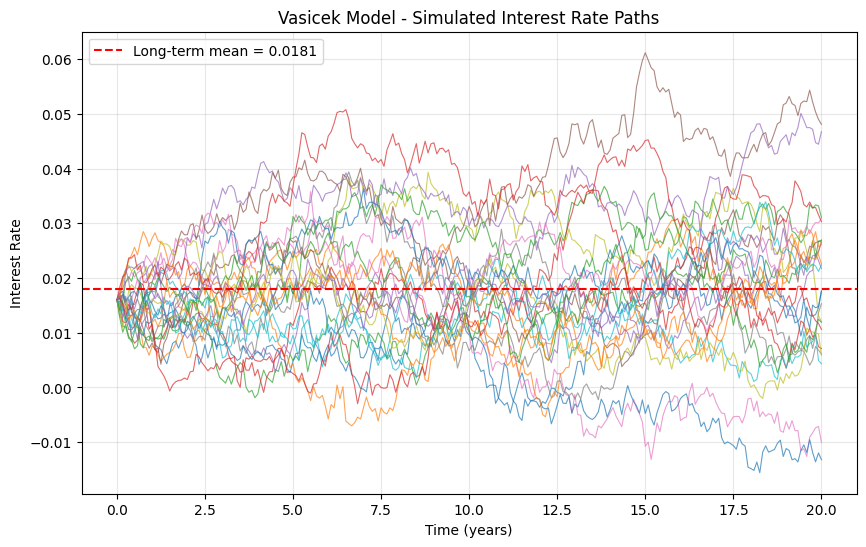

Generated 25 paths
Final rates: mean = 0.018879, std = 0.014297


In [173]:
def generate_paths(num_paths, num_steps, time_horizon=30):

    # Create Vasicek process
    vasicek_process = ql.ExtendedOrnsteinUhlenbeckProcess(
        a,
        sigma,
        r0,
        lambda t: b
    )
    # Time grid
    dt = time_horizon / num_steps
    times = [i * dt for i in range(num_steps + 1)]
    time_grid = ql.TimeGrid(times)

    # Generate paths
    all_paths = []
    for i in range(num_paths):
        rng = ql.UniformRandomSequenceGenerator(num_steps, ql.UniformRandomGenerator(1000+i))
        seq = ql.GaussianRandomSequenceGenerator(rng)
        sample = seq.nextSequence()
        randoms = sample.value()
        
        path = [r0]
        current_rate = r0
        
        for j in range(num_steps):
            current_rate = vasicek_process.evolve(times[j], current_rate, dt, randoms[j])
            path.append(current_rate)
        
        all_paths.append(path)
    
    return times, np.array(all_paths)


antal_scenarier = 25
tidsskridt = 20 * 12  # 20 years * 12 months

tidspunkter, rente_stier = generate_paths(antal_scenarier, tidsskridt, 20)

# Plot
plt.figure(figsize=(10, 6))
for i in range(antal_scenarier):
    plt.plot(tidspunkter, rente_stier[i], alpha=0.7, linewidth=0.8)

plt.axhline(y=b, color='red', linestyle='--', label=f'Long-term mean = {b:.4f}')
plt.title('Vasicek Model - Simulated Interest Rate Paths')
plt.xlabel('Time (years)')
plt.ylabel('Interest Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Generated {antal_scenarier} paths")
print(f"Final rates: mean = {np.mean(rente_stier[:, -1]):.6f}, std = {np.std(rente_stier[:, -1]):.6f}")


# Prepayment model
Vi skal udvikle en prepayment-model for at forudsige, hvornår låntagere vil vælge at omlægge deres lån. 
Dette afhænger primært af, om de kan opnå en lavere månedlig ydelse. Her vil det være fordelagtigt at inkludere en række forskellige input (såsom makroøkonomiske variable og adfærdsbestemmende variable) og derefter anvende f.eks. gradient boosting til at opnå et præcist estimat for inputtet til fordelingsfunktionen. Vi antager at renten på den nye realkreditobligation er 100 bps højere end kort-renten.


In [174]:
my = 0.150
prepaysigma = 0.07
def forudbetalingssandsynlighed(rente, restgæld, resterende_terminer, ydelse):
    rente_m = (rente+0.01) / 12
    

    ny_ydelse = npf.pmt(rate=rente_m, nper=resterende_terminer, pv=-restgæld*(1+0.007))
    gevinst_ved_forudbetaling = ydelse / ny_ydelse - 1
    if gevinst_ved_forudbetaling < 0:
        sandsynlighed = 0  
    else:
        sandsynlighed = ss.norm.cdf(gevinst_ved_forudbetaling, my, prepaysigma)
    return sandsynlighed

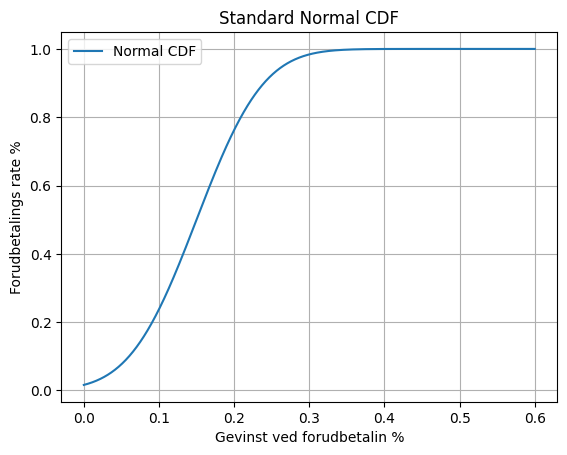

In [175]:
x = np.linspace(0, 0.6, 1000)
y = ss.norm.cdf(x, my, prepaysigma)
plt.plot(x, y, label="Normal CDF")
plt.title("Standard Normal CDF")
plt.xlabel("Gevinst ved forudbetalin %")
plt.ylabel("Forudbetalings rate %")
plt.grid(True)
plt.legend()
plt.show()

# Model
Vi har nu de nødvendige redskaber for at kunne udregne pengestrømmene over de forskellige rentestier

In [177]:
# Parametre for obligation
hovedstol = 100
kuponrente = 0.035
antal_terminer = 20 * 12
kuponrente_m = kuponrente / 12
ydelse = npf.pmt(rate=kuponrente_m, nper=antal_terminer, pv=-hovedstol)

antal_scenarier = 100
tidspunkter, rente_stier = generate_paths(antal_scenarier, antal_terminer)

npv_stier = []
afslutningstidspunkter = []

for i in range(antal_scenarier):
    rente_sti = rente_stier[i, :]
    restgæld = hovedstol
    nutidsværdi = 0
    
    for måned in range(antal_terminer+1):
        if restgæld <= 0:
            break
        
        resterende_terminer = antal_terminer - måned
        tid = (måned + 1) / 12
        indeks = min(int(tid * 12) - 1, len(rente_sti) - 1)
        rente = rente_sti[indeks]

        # Forudbetaling
        forudbetaling_sandsynlighed = forudbetalingssandsynlighed(rente, restgæld, resterende_terminer, ydelse)
        hvis_forudbetalt = np.random.rand() < forudbetaling_sandsynlighed if måned % 3 == 0 else 0

        rentebetaling = restgæld * kuponrente_m
        afdrag = ydelse - rentebetaling
        forudbetaling = hvis_forudbetalt * max(restgæld - afdrag, 0)

        samlet_afdrag = afdrag + forudbetaling
        restgæld -= samlet_afdrag

        betalingsstrøm = rentebetaling + samlet_afdrag

        integral = np.sum(rente_sti[:indeks+1]) * (1/12)
        diskonteringsfaktor = np.exp(-integral)
        nutidsværdi += diskonteringsfaktor * betalingsstrøm
    afslutningstidspunkter.append(måned)
    npv_stier.append(nutidsværdi)

print(f"Gennemsnitlig NPV: {np.mean(npv_stier):.2f}")
print(f"Standardafvigelse: {np.std(npv_stier):.2f}%")
print(f"Gennemsnitlig termin for fuld tilbagebetaling: {np.mean(afslutningstidspunkter):.2f}")


Gennemsnitlig NPV: 102.49
Standardafvigelse: 2.61%
Gennemsnitlig termin for fuld tilbagebetaling: 29.29


# Sammenligning uden forudbetaling
Vi kan bare gentage udregningen, men bare uden forudbetalingsdelen

In [178]:
# Parametre for obligation
hovedstol = 100
kuponrente = 0.035
antal_terminer = 20 * 12
kuponrente_m = kuponrente / 12
ydelse = npf.pmt(rate=kuponrente_m, nper=antal_terminer, pv=-hovedstol)

antal_scenarier = 100
tidspunkter, rente_stier = generate_paths(antal_scenarier, antal_terminer)

npv_stier = []
afslutningstidspunkter = []

for i in range(antal_scenarier):
    rente_sti = rente_stier[i, :]
    restgæld = hovedstol
    nutidsværdi = 0
    
    for måned in range(antal_terminer+1):
        if restgæld <= 0:
            break
        
        resterende_terminer = antal_terminer - måned
        tid = (måned + 1) / 12
        indeks = min(int(tid * 12) - 1, len(rente_sti) - 1)
        rente = rente_sti[indeks]


        forudbetaling_sandsynlighed = 0 # Uden forudbetaling
        hvis_forudbetalt = np.random.rand() < forudbetaling_sandsynlighed if måned % 3 == 0 else 0

        rentebetaling = restgæld * kuponrente_m
        afdrag = ydelse - rentebetaling
        forudbetaling = hvis_forudbetalt * max(restgæld - afdrag, 0)

        samlet_afdrag = afdrag + forudbetaling
        restgæld -= samlet_afdrag

        betalingsstrøm = rentebetaling + samlet_afdrag

        integral = np.sum(rente_sti[:indeks+1]) * (1/12)
        diskonteringsfaktor = np.exp(-integral)
        nutidsværdi += diskonteringsfaktor * betalingsstrøm
    afslutningstidspunkter.append(måned)
    npv_stier.append(nutidsværdi)


print(f"Gennemsnitlig NPV: {np.mean(npv_stier):.2f}")
print(f"Standardafvigelse: {np.std(npv_stier):.2f}%")
print(f"Gennemsnitlig termin for fuld tilbagebetaling: {np.mean(afslutningstidspunkter):.2f}")


Gennemsnitlig NPV: 119.05
Standardafvigelse: 7.71%
Gennemsnitlig termin for fuld tilbagebetaling: 240.00


# Konklusion

Vi ser at vi få en langt lavere værdi $119.63-103.08 \approx 16$, når vi modellerer for forudbetalingsrisiko. Dog er vi stadig et godt
stykke fra markedsværdi. En realkreditobligation 3,5% 2046 med afdrag er åben for tilbud på 97,55.
Samlet set skyldes dette antageligt problemer med den underliggende rentemodel og
modelleringen af tilbagebetalingsrisiko. Modellen viser de underliggende ideer bag ved prissætning
af realkreditobligationer, men er stadig langt fra markedspriser.
